In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import sys
import src.SABR.sabr
import src.SABR.sabr_approx
reload(src.SABR.sabr)
reload(src.SABR.sabr_approx)
# from src.SABR.sabr import calibrate_sabr
from src.SABR.sabr_approx import calibrate_sabr
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

CPU times: user 22.5 s, sys: 4.87 s, total: 27.4 s
Wall time: 37.6 s


<AxesSubplot: >

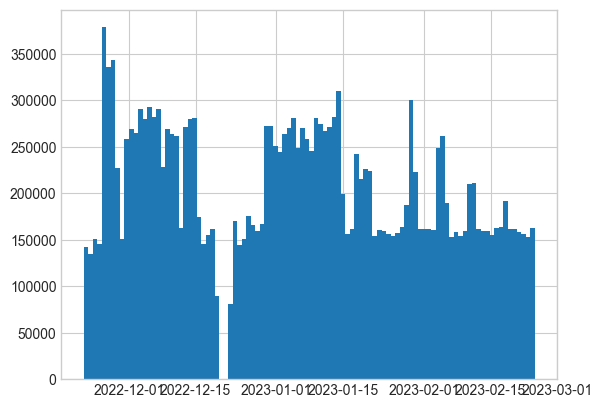

In [3]:
%%time
# heavy
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
raw.dt.hist(bins = 100)

In [4]:
%%time
df = process_data(raw)
df.head()

CPU times: user 51.1 s, sys: 25.7 s, total: 1min 16s
Wall time: 2min 10s


,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.9,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.9,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.9,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.9,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.9,1669036104511000


# Params dynamics

In [6]:
df.sample(1)

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
2801479,2022-12-30 15:06:30.703,0.056,ETH-13JAN23-1150-C,call,1150,1673568000000000,1186.35,1672412790703000


In [7]:
find_beta_for_expiration(df, 1672412790703000)

KeyError: "['mark_iv'] not in index"

In [8]:
# def find_beta_for_expiration(single_expiration: pd.DataFrame, filter_timestamp=None):
#     # if filter_timestamp is given, build regression only on data before that timestamp
#     if filter_timestamp:
#         single_expiration = single_expiration[
#             single_expiration["timestamp"] <= filter_timestamp
#         ]

#     def get_closest(given_strikes, underlying_price):
#         """Finds between which values the given onw lies"""
#         # given_strikes sorted
#         for index in range(0, len(given_strikes) - 1):
#             if (
#                 given_strikes[index] <= underlying_price
#                 and given_strikes[index + 1] >= underlying_price
#             ):
#                 return given_strikes[index], given_strikes[index + 1]

#     def get_mid_mark_iv(forward: float):
#         closest_strikes = get_closest(all_covered_strikes, forward)
#         return closest_strikes

#     available_strikes = sorted(single_expiration.strike_price.unique())
#     max_value_of_underlying = single_expiration.underlying_price.max()
#     min_value_of_underlying = single_expiration.underlying_price.min()

#     # find between which strikes do max and min forward values are
#     right_border = get_closest(available_strikes, max_value_of_underlying)[1]
#     left_border = get_closest(available_strikes, min_value_of_underlying)[0]
#     all_covered_strikes = [
#         strike
#         for strike in available_strikes
#         if strike >= left_border and strike <= right_border
#     ]

#     # find between whick strikes one current tick the forward is
#     single_expiration["closest_strikes"] = single_expiration["underlying_price"].apply(
#         get_mid_mark_iv
#     )
#     # make borders as columns
#     single_expiration["left_border"] = single_expiration["closest_strikes"].apply(
#         lambda x: x[0]
#     )
#     single_expiration["right_border"] = single_expiration["closest_strikes"].apply(
#         lambda x: x[1]
#     )

#     # ticks of only crossed strikes
#     df_of_only_needed_strikes = single_expiration[
#         single_expiration["strike_price"].isin(all_covered_strikes)
#     ]
#     df_of_only_needed_strikes = (
#         df_of_only_needed_strikes[["timestamp", "strike_price", "mark_iv"]]
#         .drop_duplicates()
#         .copy()
#     )

#     # get for all timstamps the values of mark_iv for needed strikes
#     df_of_only_needed_strikes_left = df_of_only_needed_strikes.copy()
#     df_of_only_needed_strikes_left = df_of_only_needed_strikes_left.rename(
#         columns={"mark_iv": "mark_iv_left"}
#     )
#     single_expiration = single_expiration.merge(
#         df_of_only_needed_strikes_left,
#         how="left",
#         left_on=["timestamp", "left_border"],
#         right_on=["timestamp", "strike_price"],
#     )
#     # same for right ordered
#     df_of_only_needed_strikes_right = df_of_only_needed_strikes.copy()
#     df_of_only_needed_strikes_right = df_of_only_needed_strikes_right.rename(
#         columns={"mark_iv": "mark_iv_right"}
#     )
#     single_expiration = single_expiration.merge(
#         df_of_only_needed_strikes_right,
#         how="left",
#         left_on=["timestamp", "right_border"],
#         right_on=["timestamp", "strike_price"],
#     )
#     # drop useless cols
#     single_expiration = single_expiration.drop(
#         columns=["strike_price_y", "strike_price"]
#     )
#     single_expiration = single_expiration.rename(
#         columns={"strike_price_x": "strike_price"}
#     )
#     # if there are no info on mark_iv of given strike for this tick, fill with previous value
# #     single_expiration["mark_iv_left"] = single_expiration["mark_iv_left"].fillna(
# #         method="ffill"
# #     )
# #     single_expiration["mark_iv_right"] = single_expiration["mark_iv_right"].fillna(
# #         method="ffill"
# #     )

#     # get no similar by this cols ticks
#     only_needed = single_expiration[
#         [
#             "timestamp",
#             "underlying_price",
#             "right_border",
#             "left_border",
#             "mark_iv_left",
#             "mark_iv_right",
#             "strike_price",
#             "mark_iv",
#         ]
#     ].copy()
#     only_needed = only_needed.dropna()
#     #     only_needed = only_needed[only_needed["strike_price"].isin(all_covered_strikes)]

#     # weight needed vols by distance between forward and closest strikes
#     only_needed["ATM_iv"] = only_needed["mark_iv_left"] * (
#         only_needed["right_border"] - only_needed["underlying_price"]
#     ) / (only_needed["right_border"] - only_needed["left_border"]) + only_needed[
#         "mark_iv_right"
#     ] * (
#         only_needed["underlying_price"] - only_needed["left_border"]
#     ) / (
#         only_needed["right_border"] - only_needed["left_border"]
#     )

#     # get logs for regression
#     only_needed["ln_underlying_price"] = np.log(only_needed["underlying_price"])
#     only_needed["ln_ATM_iv"] = np.log(only_needed["ATM_iv"])
#     to_fit = only_needed[["ln_underlying_price", "ln_ATM_iv"]].drop_duplicates().copy()


#     lr = LinearRegression()
#     lr.fit(to_fit["ln_underlying_price"].values.reshape(-1, 1), to_fit["ln_ATM_iv"])
#     k = lr.coef_[0]
#     alpha = lr.intercept_
#     # from formula
#     beta = k + 1
#     # just to see the dependency
# #     xx = np.linspace(
# #         to_fit["ln_underlying_price"].max(), to_fit["ln_underlying_price"].min(), 100
# #     )
# #     yy = k * xx + alpha
# #     plt.scatter(to_fit["ln_underlying_price"], to_fit["ln_ATM_iv"])
# #     plt.plot(xx, yy, color="orange")

# #     results = sm.ols(formula="ln_ATM_iv~ln_underlying_price", data=to_fit).fit()
# #     results.summary()
#     beta = max(min(beta, 1.0), 0.0)
#     return beta


In [22]:
%%time
number_of_dots = 100
timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(1.0)
v = np.float64(1.3)
beta = np.float64(0.5)  
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta", beta = 1.0)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
print("Beta first calibrated:", round_params(calibrated_params_beta), "error:", first_error_beta)


timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    # zero params for each point are params from last step
    calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                timestamp = timestamp, calibration_type = "all")
#         print("All calibrated:", round_params(calibrated_params_all), "error:", error_all)

    calibrated_params_beta, error_beta, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                timestamp = timestamp, calibration_type = "beta", beta = 1.0)
#         print("nu0 calibrated:", round_params(calibrated_params_beta), "error:", error_beta)

    params_all.append(calibrated_params_all)
    errors_all.append(error_all)
    params_beta.append(calibrated_params_beta)
    errors_beta.append(error_beta)
    timestamps_hm.append(timestamp)
        
#         print("    ")

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [50.0, 4.546, 0.402, 0.031] error: 0.0096362068721377
Beta first calibrated: [0.591, 4.569, 1.0, -0.132] error: 0.010729646330994444


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 9.74 s, sys: 120 ms, total: 9.86 s
Wall time: 9.84 s


In [12]:
params_all

array([], dtype=float64)

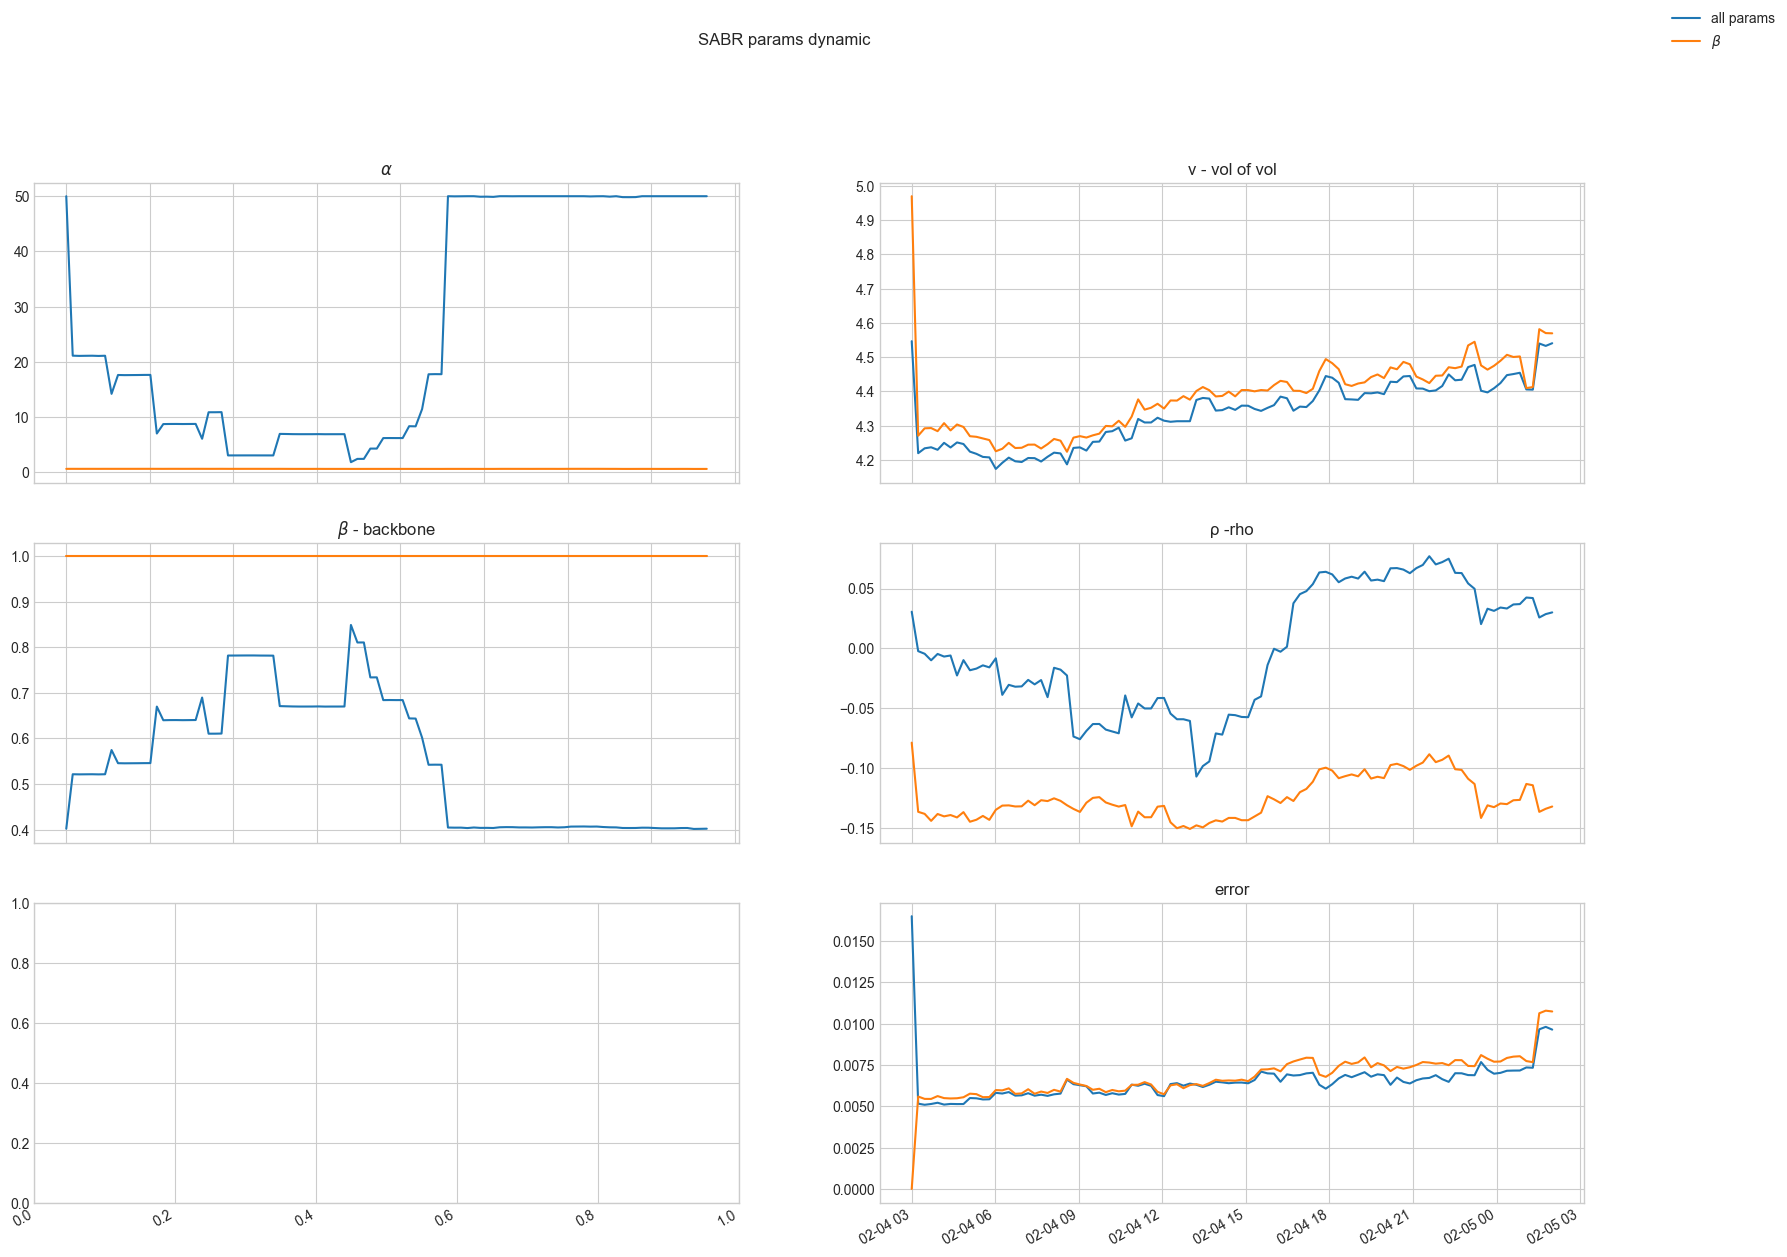

In [23]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0], label = "all params")
axs[0, 1].plot(timestamps_hm, params_all[1])
axs[1, 0].plot(timestamps_hm, params_all[2])
axs[1, 1].plot(timestamps_hm, params_all[3])
axs[2, 1].plot(timestamps_hm, errors_all)

axs[0, 0].plot(timestamps_hm, params_beta[0], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm, params_beta[1])
axs[1, 0].plot(timestamps_hm, params_beta[2])
axs[1, 1].plot(timestamps_hm, params_beta[3])
axs[2, 1].plot(timestamps_hm, errors_beta)


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")

plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Volatility smile

In [6]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0].timestamp
print(needed_stamp)

1676561187718000


In [17]:
alpha = np.float64(1.0) 
v = np.float64(1.3) 
beta = np.float64(0.5) 
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "beta")


print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


All:
[18.312, 6.396, 0.536, -0.003]
0.006995247906208326
   
Beta:
[0.583, 6.464, 1.0, -0.103]
0.007404794486691667


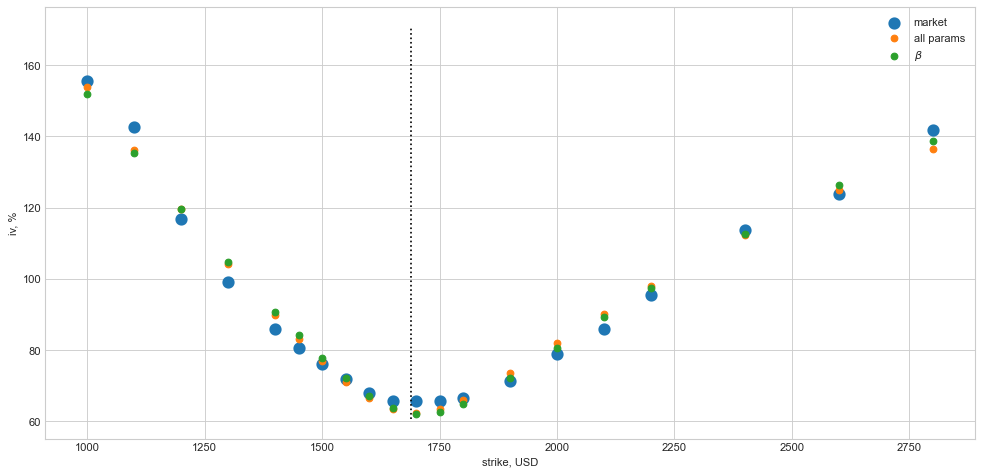

In [8]:
figure(figsize=(15, 7), dpi=80)

plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()